In [1]:
import pandas as pd
import numpy as np

Load data

In [2]:
all_data = pd.read_csv("../RideData/all_trips.csv")

Feature engineering: adding day of month and day of week into dataset

In [3]:
all_data_dup = all_data
all_data_dup['Date'] = pd.to_datetime(all_data_dup['Date'])
all_data_dup['Day'] = all_data_dup['Date'].dt.day
all_data_dup['trips_binary'] = (all_data_dup['trips'] != 0).astype(int)

Spliting dependent and independent variables; creating dummy variables for categorical columns

In [4]:
X = all_data_dup[['Start_station','Start_cluster','End_station','End_cluster', 'Month','Day','Weekday']]
y = all_data_dup['trips_binary']
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X_enc = pd.DataFrame(enc.fit_transform(X).toarray())

Using 2019 data as training and 2020 data as testing

In [5]:
train_split = (all_data_dup['Date'].dt.year == 2019).value_counts()[0]

In [6]:
X_tr = X_enc[:(train_split+1)].values
X_te = X_enc[train_split:].values
y_tr = y[:(train_split+1)].values
y_te = y[train_split:].values

### Deep Neural Net

In [8]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.fit(X_tr, y_tr, epochs=6)

Train on 1895076 samples
Epoch 1/6
1895076/1895076 [==============================] - 241s 127us/sample - loss: 0.0743 - accuracy: 0.9766
Epoch 2/6
1895076/1895076 [==============================] - 233s 123us/sample - loss: 0.0683 - accuracy: 0.9773
Epoch 3/6
1895076/1895076 [==============================] - 233s 123us/sample - loss: 0.0667 - accuracy: 0.9778
Epoch 4/6
1895076/1895076 [==============================] - 270s 143us/sample - loss: 0.0658 - accuracy: 0.9781
Epoch 5/6
1895076/1895076 [==============================] - 277s 146us/sample - loss: 0.0653 - accuracy: 0.9782
Epoch 6/6
1895076/1895076 [==============================] - 251s 132us/sample - loss: 0.0648 - accuracy: 0.9783


In [12]:
model.save("/Users/rongkui/Desktop/Classes/STA208/Project/binary_dnn")

INFO:tensorflow:Assets written to: /Users/rongkui/Desktop/Classes/STA208/Project/binary_dnn/assets


In [7]:
import tensorflow as tf
model = tf.keras.models.load_model("/Users/rongkui/Desktop/Classes/STA208/Project/binary_dnn")

Confusion matrix:

In [8]:
y_pred = model.predict(X_te, verbose=2)
y_pred_df = pd.DataFrame(y_pred, columns = [0, 1])
y_pred_recon = np.array(y_pred_df.idxmax(axis=1))
pd.Series(y_pred_recon).to_csv("RelevantData/DNN_pred.csv")

7601125/1 - 306s


In [1]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_te, y_pred_recon), columns = ['y_te negative','y_te positive'])
cm['Prediction'] = pd.Series(['y_pred negative','y_pred positive'])
cm = cm[['Prediction','y_te negative','y_te positive']]
cm = cm.set_index('Prediction')
cm.to_csv("RelevantData/DNN_ConfMat.csv")

In [11]:
from sklearn.metrics import precision_recall_curve
precision_keras, recall_keras, thresholds_keras = precision_recall_curve(y_te, y_pred_recon)

In [12]:
pr = pd.DataFrame({'Precision':precision_keras, 'Recall':recall_keras})
pr.to_csv("RelevantData/Binary_DNN_PR.csv")

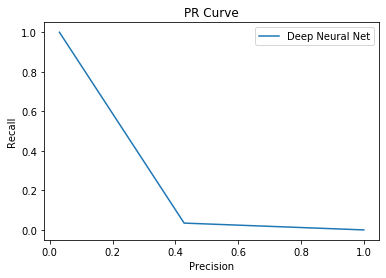

In [20]:
pr = pd.read_csv("RelevantData/Binary_DNN_PR.csv")
precision_keras = pr['Precision'].values
recall_keras = pr['Recall'].values
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(precision_keras, recall_keras, label='Deep Neural Net')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR Curve')
plt.legend(loc='best')
plt.show()